In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader

In [2]:
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
train_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s] 


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
n_epochs = 10

In [13]:
for epoch in range(n_epochs):  # Change as needed
    model.train()
    total_loss = 0
    start = time.time()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
    print("Time taken: ", time.time() - start)


Epoch 1, Loss: 0.1555
Time taken:  126.06395363807678
Epoch 2, Loss: 0.0379
Time taken:  86.23038959503174
Epoch 3, Loss: 0.0195
Time taken:  87.28127026557922
Epoch 4, Loss: 0.0190
Time taken:  86.07879590988159
Epoch 5, Loss: 0.0256
Time taken:  86.11917972564697
Epoch 6, Loss: 0.0117
Time taken:  86.81660771369934
Epoch 7, Loss: 0.0146
Time taken:  86.58291172981262
Epoch 8, Loss: 0.0102
Time taken:  86.36071372032166
Epoch 9, Loss: 0.0261
Time taken:  86.36893606185913
Epoch 10, Loss: 0.0172
Time taken:  86.83613157272339


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [15]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Binarize predictions with threshold 0.5
all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]

# Metrics
accuracy = accuracy_score(all_labels, all_preds_bin)
precision = precision_score(all_labels, all_preds_bin)
recall = recall_score(all_labels, all_preds_bin)
f1 = f1_score(all_labels, all_preds_bin)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Accuracy:  0.6907
Precision: 0.6690
Recall:    1.0000
F1 Score:  0.8016
ROC-AUC:   0.9201


In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

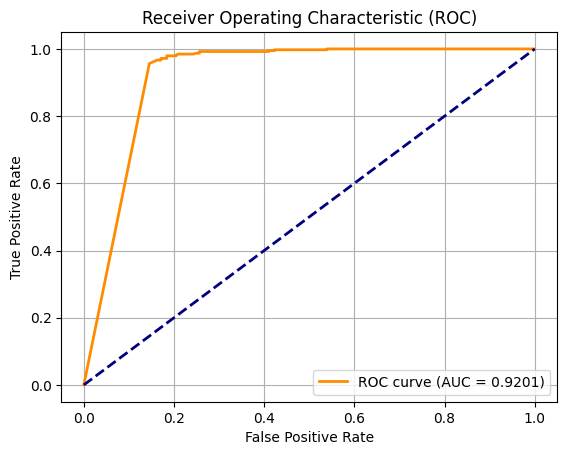

In [17]:
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()